This file contains:

1. Unigram Vocabulary
2. Skipgram Vocabulary from scratch
3. word-word co-occurrence matrix
4. Vector similarity based on cosine distance.
5. Normalized word-word co-occurrence matrix
6. Vector similarity based on normalized matrix
7. PMI : Pointwise Mutual Information Matrices
8. Smoothed PMI
9. SVD(Singular Value Decomposition)


https://www.kaggle.com/code/gabrielaltay/word-vectors-from-pmi-matrix/notebook

In [12]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np
from sklearn.preprocessing import normalize

from collections import Counter
from scipy import sparse
from scipy.sparse import linalg
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df = pd.read_csv('abcnews-date-text.csv')
print(df.head())

   publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers


In [14]:
headlines = df['headline_text'].tolist()
# print(headlines)

We're going to create a word-word co-occurrence matrix from the text in the headlines. We will define two words as "co-occurring" if they appear in the same headline. Using this definition, single word headlines are not interesting for us. Lets remove them as well as a common set of english stopwords

In [15]:
stop_words = set(stopwords.words('english'))
# print(len(stop_words))

# splitting tokens and removing stop words
headlines = [
             [tok for tok in headline.split() if tok not in stop_words] for headline in headlines
]

print('Total Number of headlines are :', len(headlines))

# Removing single token headlines
headlines = [hl for hl in headlines if len(hl) > 1]
print('\n First 20 headlines look like:', headlines[:20])

Total Number of headlines are : 1103663

 First 20 headlines look like: [['aba', 'decides', 'community', 'broadcasting', 'licence'], ['act', 'fire', 'witnesses', 'must', 'aware', 'defamation'], ['g', 'calls', 'infrastructure', 'protection', 'summit'], ['air', 'nz', 'staff', 'aust', 'strike', 'pay', 'rise'], ['air', 'nz', 'strike', 'affect', 'australian', 'travellers'], ['ambitious', 'olsson', 'wins', 'triple', 'jump'], ['antic', 'delighted', 'record', 'breaking', 'barca'], ['aussie', 'qualifier', 'stosur', 'wastes', 'four', 'memphis', 'match'], ['aust', 'addresses', 'un', 'security', 'council', 'iraq'], ['australia', 'locked', 'war', 'timetable', 'opp'], ['australia', 'contribute', '10', 'million', 'aid', 'iraq'], ['barca', 'take', 'record', 'robson', 'celebrates', 'birthday'], ['bathhouse', 'plans', 'move', 'ahead'], ['big', 'hopes', 'launceston', 'cycling', 'championship'], ['big', 'plan', 'boost', 'paroo', 'water', 'supplies'], ['blizzard', 'buries', 'united', 'states', 'bills'], ['

**Unigrams** : we will give unique ID to each token and create two dictionaries for mapping from **tok2indx and indx2tok**.
We will also count how often each token appears in the corpus

In [16]:
unigram_counts = Counter()
for headline in headlines:
  for token in headline:
    unigram_counts[token] += 1

print(unigram_counts)
print(unigram_counts.keys())
print(f'Vocabulary Size is {len(unigram_counts)}')
print(f'Most common words are : {unigram_counts.most_common(10)}')

Counter({'police': 35954, 'new': 29087, 'man': 27976, 'says': 20001, 'us': 17498, 'govt': 16921, 'court': 16374, 'council': 16330, 'interview': 14655, 'fire': 13890, 'nsw': 12898, 'australia': 12303, 'plan': 12297, 'water': 11863, 'qld': 11778, 'wa': 11499, 'crash': 11188, 'death': 11138, 'sydney': 10574, 'health': 10362, 'australian': 10336, 'charged': 10147, 'back': 10119, 'report': 9573, 'call': 9280, 'murder': 9195, 'sa': 9096, 'hospital': 8804, 'day': 8778, 'car': 8675, 'may': 8539, 'calls': 8400, 'coast': 8398, 'win': 8294, 'woman': 8198, 'two': 8164, 'killed': 8098, 'accused': 8093, 'world': 8071, 'south': 7898, 'government': 7889, 'urged': 7841, 'home': 7834, 'found': 7834, 'missing': 7564, 'first': 7543, 'rural': 7374, 'north': 7356, 'set': 7310, 'claims': 7229, 'election': 7176, 'school': 7134, 'attack': 7129, 'cup': 7091, 'minister': 7022, 'wins': 7010, 'boost': 6993, 'dies': 6919, 'face': 6905, 'market': 6814, 'funding': 6766, 'help': 6765, 'talks': 6697, 'child': 6655, 'gr

In [17]:
# Creating two dictionaries : tok2indx and indx2tok
tok2indx = {key:ii for ii, key in enumerate(unigram_counts.keys())}
indx2tok = {indx:tok for tok, indx in tok2indx.items()}

# tok2indx = {'abc':1, 'police':2}
# indx2tok = {'police':2, 'abc':1}

**skipgram vocabulary** : Predict the context words given a target word. 


Now lets calculate a skipgram vocabulary. We will loop through each word in a headline (the focus word) and then form skipgrams by examing back_window words behind and front_window words in front of the focus word (the context words). As an example, the first sentence (after preprocessing removes the stopword against) ,

**aba decides community broadcasting licence**


would produce the following skipgrams with back_window=front_window=2,

('aba', 'decides')

('aba', 'community')

('decides', 'aba')

('decides', 'community')

('decides', 'broadcasting')

('community', 'aba')

('community', 'decides')

('community', 'broadcasting')

('community', 'licence')

('broadcasting', 'decides')

('broadcasting', 'community')

('broadcasting', 'licence')

('licence', 'community')

('licence', 'broadcasting')


In [18]:
back_window = 2
front_window = 2

skipgram_counts = Counter()

# headlines = headlines[:2]
#print(headlines)

for i_headline, headline in enumerate(headlines):
  # print(headline)
  #min_ = []
  #max_ = []
  tokens = [tok2indx[tok] for tok in headline]
  #print(tokens)
  
  for i_word, word in enumerate(tokens):
    #print(i_word, word)
    ii_context_min = max(0, i_word - back_window)
    ii_context_max = min(len(headline) - 1, i_word + front_window)

    # min_.append(ii_context_min)
    # max_.append(ii_context_max)

    ii_contexts = [ii for ii in range(ii_context_min, ii_context_max+1) if ii != i_word]
    #print(i_word, ii_contexts)

    for i in ii_contexts:
      skipgram = (tokens[i_word],tokens[i])
      skipgram_counts[skipgram] += 1

print(f'Number of skipgrams are :', len(skipgram_counts))
print(f'Most common skipgrams are :', skipgram_counts.most_common(10))    
print([((indx2tok[sg[0][0]], indx2tok[sg[0][1]]), sg[1]) for sg in skipgram_counts.most_common(10)])

Number of skipgrams are : 7790955
Most common skipgrams are : [((351, 394), 3727), ((394, 351), 3727), ((522, 6332), 3713), ((6332, 522), 3713), ((274, 275), 3091), ((275, 274), 3091), ((520, 828), 2704), ((828, 520), 2704), ((1030, 1031), 2116), ((1031, 1030), 2116)]
[(('man', 'charged'), 3727), (('charged', 'man'), 3727), (('country', 'hour'), 3713), (('hour', 'country'), 3713), (('gold', 'coast'), 3091), (('coast', 'gold'), 3091), (('world', 'cup'), 2704), (('cup', 'world'), 2704), (('pleads', 'guilty'), 2116), (('guilty', 'pleads'), 2116)]


**word-word matrix** : This is a co-occurrence matrix for words and this is symmetric. So our respective rows and columns will be same. we will consider rows as words and columns as context words. 

For createing this matrix we will use scipy.sparse.csr_matrix - it needs three inputs. Rows, columns and data values.

I have len(vocab) words at rows and at columns. The order of the words is based on list of tokens for rows and list of tokens for columns created from skipgram_counts.

reference : https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [19]:
# print(list(skipgram_counts.items())[:10])

row_indxs = []
col_indxs = []
dat_values = []

for (tok1, tok2), value in skipgram_counts.items():
  row_indxs.append(tok1)
  col_indxs.append(tok2)
  dat_values.append(value)


# print(row_indxs[:10], col_indxs[:10], dat_values[:10])
ww_matrix = sparse.csr_matrix((dat_values, (row_indxs, col_indxs)))
print(ww_matrix.shape)
print(ww_matrix[:18,:18].toarray())

(106584, 106584)
[[  0   1   1   1   0   0   0   0   1   0   0   0   1   0   0   0   0   0]
 [  1   0   1   1   0   1   0   0   0   0   1   0   0   0   0   0   0   0]
 [  1   1   0   1   2  13  27   0  13   2   0   2  53   4   4   1   7   1]
 [  1   1   1   0   1   1   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   2   1   0   0   1   0   1   0   0   0   6   0   0   0   2   0]
 [  0   1  13   1   0  10  60   1  32   0   2   4  46   4  19   2   4   0]
 [  0   0  27   0   1  60  18   7   6   3   0   3  30   1  14   2  12  13]
 [  0   0   0   0   0   1   7   0   1   1   0   0   8   0   1   0   3   0]
 [  1   0  13   0   1  32   6   1   0   1   1   3   0   6   3   2   0   1]
 [  0   0   2   0   0   0   3   1   1   0   1   2   0   0   0   0   1   0]
 [  0   1   0   0   0   2   0   0   1   1   0   3   0   0   0   0   1   0]
 [  0   0   2   0   0   4   3   0   3   2   3 422  24   2   0   2   1   1]
 [  1   0  53   0   6  46  30   8   0   0   0  24   0  20  36  14   8  14]
 [  0   

**Word Similarity based on Sparse Count Matrices** : Now we calculate top n most similar words based on above matrix using cosine similarity.

In [37]:
def ww_sim(word, matrix, topn=10):
  """ Calculate topn most similar words to a word."""

  indx = tok2indx[word]
  if isinstance(matrix, sparse.csr_matrix):
    row_value = matrix.getrow(indx)
  else:
    row_value = matrix[indx, :]

  print(row_value.shape)

  sims = cosine_similarity(matrix, row_value)
  sims = sims.flatten()
  sim_indices = np.argsort(-sims)
  similar_words = [(indx2tok[index], sims[index]) for index in sim_indices[0:topn]]
  return similar_words 

similar_words = ww_sim('strike', ww_matrix)
similar_words = np.array(similar_words).reshape(10,-1)
print(f'Most similar top 10 words to "strike" are : \n {similar_words}')

(1, 106584)
Most similar top 10 words to "strike" are : 
 [['strike' '1.0000000000000449']
 ['strikes' '0.4904853293642246']
 ['striking' '0.45385237096853437']
 ['accept' '0.4459920353013641']
 ['underpaid' '0.43881538653771157']
 ['threaten' '0.4362951198583216']
 ['dispute' '0.4256212798547871']
 ['industrial' '0.42389192325699226']
 ['sacked' '0.41940578456659355']
 ['strike;' '0.4070193440823727']]


**Normalization :** It is always recommendated to do normalization when calculating word similarity. We normalize each row of a word-word co-occurrence matrix.


In [21]:
normalized_ww_matrix = normalize(ww_matrix, norm = 'l2', axis = 1)


# Cheking Normalization : magnitude of normalized vector is always equal to 1.
row = ww_matrix.getrow(10).toarray().flatten()
#print(np.sqrt((row*row).sum()))

row = normalized_ww_matrix.getrow(10).toarray().flatten()
#print(np.sqrt((row*row).sum()))


# now we calculate the word similarity using normalized word-word co-occurrence matrix
similar_words_normalized = ww_sim('strike', normalized_ww_matrix)
similar_words_normalized = np.array(similar_words_normalized).reshape(10,-1)
print(f'Most similar top 10 words to "strike" are : \n {similar_words_normalized}')

Most similar top 10 words to "strike" are : 
 [['strike' '1.000000000000001']
 ['strikes' '0.490485329364205']
 ['striking' '0.4538523709685223']
 ['accept' '0.4459920353013513']
 ['underpaid' '0.43881538653770225']
 ['threaten' '0.4362951198583179']
 ['dispute' '0.4256212798547619']
 ['industrial' '0.4238919232569745']
 ['sacked' '0.4194057845665867']
 ['strike;' '0.4070193440823636']]


**PMI : Pointwise Mutual Information Matrix**

The pointwise mutual information (PMI) for a (word, context) pair in our corpus is defined as the probability of their co-occurrence divided by the probabilities of them appearing individually,

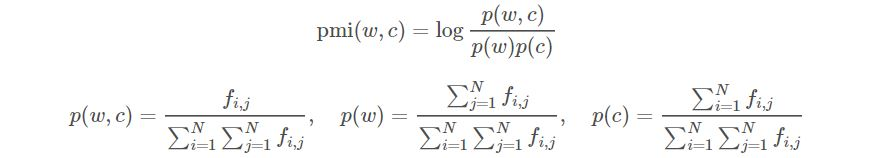
 
where  fi,j  is the word-word count matrix we defined above. In addition we can define the positive pointwise mutual information as,

**ppmi(w,c)= max[pmi(w,c),0]**
 
Note that the definition of PMI above implies that  pmi(w,c)=pmi(c,w)  and so this matrix will be symmetric. However this is not true for the variant in which we smooth over the contexts.

In [22]:
# adding the entries from whole word-word matrix
skipgrams_total = ww_matrix.sum()
#print(num_skipgrams)

assert(sum(skipgram_counts.values()) == skipgrams_total)

# For creating sparse matrices later on 
row_indxs = []
col_indxs = []
pmi_dat_values = []
ppmi_dat_values = []
spmi_dat_values = []
sppmi_dat_values = []

# 
sum_over_words = np.array(ww_matrix.sum(axis=0)).flatten()
# print(len(sum_over_words), sum_over_words)
sum_over_contexts = np.array(ww_matrix.sum(axis=1)).flatten()
# print(len(sum_over_contexts), sum_over_contexts)

In [23]:
# smoothing
alpha = 0.75
sum_over_words_alpha = sum_over_words**alpha
smoothed_denom_p_c = np.sum(sum_over_words_alpha)

In [24]:
for (tok_word, tok_context), value in skipgram_counts.items():
  #print(tok_word, tok_context, value)

  # for PMI
  # nwc = value
  p_wc = value / skipgrams_total            # scalar value
  numer_w = sum_over_contexts[tok_word]
  p_w = numer_w / skipgrams_total
  numer_c = sum_over_words[tok_context]
  p_c = numer_c / skipgrams_total

  # For smoothed PMI
  smoothed_numer = sum_over_words_alpha[tok_context]
  smoothed_p_c = smoothed_numer / smoothed_denom_p_c

  # calculate : pmi, ppmi, spmi, sppmi
  pmi = np.log2(p_wc / (p_w * p_c))
  ppmi = max(pmi, 0)
  spmi = np.log2(p_wc / (p_w * smoothed_p_c))
  sppmi = max(spmi, 0)

  row_indxs.append(tok_word)
  col_indxs.append(tok_context)
  pmi_dat_values.append(pmi)
  ppmi_dat_values.append(ppmi)
  spmi_dat_values.append(spmi)
  sppmi_dat_values.append(sppmi)



pmi_matrix = sparse.csr_matrix((pmi_dat_values, (row_indxs, col_indxs))) 
ppmi_matrix = sparse.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs))) 
spmi_matrix = sparse.csr_matrix((spmi_dat_values, (row_indxs, col_indxs))) 
sppmi_matrix = sparse.csr_matrix((sppmi_dat_values, (row_indxs, col_indxs))) 

print(pmi_matrix.shape)
print(ppmi_matrix.shape)
print(spmi_matrix.shape)
print(sppmi_matrix.shape)

(106584, 106584)
(106584, 106584)
(106584, 106584)
(106584, 106584)


In [25]:
print(len(row_indxs), len(col_indxs), len(pmi_dat_values), len(ppmi_dat_values), len(spmi_dat_values), len(sppmi_dat_values))

7790955 7790955 7790955 7790955 7790955 7790955


Now we want to calculate the word similarity based on above matrices

In [26]:
ww_sim('strike', pmi_matrix)

[('strike', 1.0000000000000013),
 ('strikes', 0.12025990247905391),
 ('dispute', 0.11375960729572165),
 ('industrial', 0.11262630844351115),
 ('workers', 0.11111231132278065),
 ('union', 0.09942079195061788),
 ('threaten', 0.09351921085090815),
 ('pay', 0.09322829109823104),
 ('teachers', 0.08981011682779347),
 ('action', 0.08919527251578693)]

In [27]:
ww_sim('strike', ppmi_matrix)

[('strike', 1.0000000000000022),
 ('strikes', 0.11886418179025696),
 ('dispute', 0.11736604633300655),
 ('industrial', 0.11734108794558719),
 ('workers', 0.11305981247766432),
 ('threaten', 0.1001427799118573),
 ('union', 0.0997946527915143),
 ('teachers', 0.09494216234236824),
 ('pay', 0.09059129507123558),
 ('action', 0.08684023153281009)]

In [28]:
ww_sim('strike', spmi_matrix)

[('strike', 1.0000000000000004),
 ('strikes', 0.15265517559961445),
 ('industrial', 0.14135259652042606),
 ('dispute', 0.1361018416667467),
 ('workers', 0.11649107993847026),
 ('threaten', 0.1149080719122813),
 ('union', 0.11033334925373915),
 ('teachers', 0.10824314364229386),
 ('protest', 0.10461628162204836),
 ('pay', 0.10179148266686096)]

In [29]:
ww_sim('strike', sppmi_matrix)

[('strike', 0.9999999999999988),
 ('strikes', 0.15779601983693906),
 ('industrial', 0.1532281862471074),
 ('dispute', 0.14756059922214562),
 ('workers', 0.1339998270140411),
 ('threaten', 0.12748948227438991),
 ('union', 0.12427861529004257),
 ('teachers', 0.12163751766902611),
 ('pay', 0.11488036504855731),
 ('irc', 0.1147067533948206)]

**Singular Value Decomposition**

With the PMI and PPMI matrices in hand, we can apply a singular value decomposition to create dense word vectors from the sparse ones we've been using.

In [39]:
pmi_use = ppmi_matrix
embedding_size = 50
uu, ss, vv = linalg.svds(pmi_use, embedding_size) 
ss = ss.reshape(-1,1)

In [40]:
print('vocab size: {}'.format(len(unigram_counts)))
print('embedding size: {}'.format(embedding_size))
print('uu.shape: {}'.format(uu.shape))
print('ss.shape: {}'.format(ss.shape))
print('vv.shape: {}'.format(vv.shape))

vocab size: 106584
embedding size: 50
uu.shape: (106584, 50)
ss.shape: (50, 1)
vv.shape: (50, 106584)


In [41]:
unorm = uu / np.sqrt(np.sum(uu*uu, axis=1, keepdims=True))
vnorm = vv / np.sqrt(np.sum(vv*vv, axis=0, keepdims=True))
#word_vecs = unorm
#word_vecs = vnorm.T
word_vecs = uu + vv.T
word_vecs_norm = word_vecs / np.sqrt(np.sum(word_vecs*word_vecs, axis=1, keepdims=True))
print(word_vecs.shape)

(106584, 50)


In [42]:
def word_sim_report(word, sim_mat):
    sim_word_scores = ww_sim(word, word_vecs)
    for sim_word, sim_score in sim_word_scores:
        print(sim_word, sim_score)
        word_headlines = [hl for hl in headlines if sim_word in hl and word in hl][0:5]
        for headline in word_headlines:
            print(f'    {headline}')